In [333]:
import msprime
from trails.cutpoints import cutpoints_ABC
import re
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [334]:
import pandas as pd
import numpy as np

n_int_AB = 1
n_int_ABC = 1
mu = 2e-8

g = 25
N_AB = 10_000*2*mu
N_ABC = 10_000*2*mu
N_ref = N_ABC
t_1 = 60_000/g*mu
t_2 = (600_000-t_1)/g*mu
t_3 = (6_000_000-t_2)/g*mu
t_A = t_1
t_B = t_1
t_C = t_1+t_2
t_m = t_1-40_000/g*mu
t_upper = t_3-cutpoints_ABC(n_int_ABC,  1/N_ABC)[-2]
t_out = t_1+t_2+t_3+2*N_ABC
r = 1e-8/mu

m = 0.05

seed = 3

In [335]:
m*(2/3)*np.exp(-(t_2+t_m)/(N_AB))+(1-m)*(2/3)*np.exp(-(t_2)/(N_AB))

0.20040247482826834

In [336]:
n_sites = 10_000_000

demography = msprime.Demography()
demography.add_population(name="A", initial_size=N_AB, default_sampling_time=t_1-t_A)
demography.add_population(name="B", initial_size=N_AB, default_sampling_time=t_1-t_B)
demography.add_population(name="B_anc", initial_size=N_AB, initially_active=False)
demography.add_population(name="C", initial_size=N_AB, default_sampling_time=t_1+t_2-t_C)
demography.add_population(name="D", initial_size=N_AB, default_sampling_time=t_1-t_1)
demography.add_population(name="AB", initial_size=N_AB)
demography.add_population(name="ABC", initial_size=N_ABC)
demography.add_population(name="ABCD", initial_size=N_ABC)
demography.add_admixture(time = t_1-t_m, derived="B", ancestral=["B_anc", "C"], proportions=(1-m, m))
demography.add_population_split(time=t_1, derived=["A", "B_anc"], ancestral="AB")
demography.add_population_split(time=t_1+t_2, derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=t_1+t_2+t_3, derived=["ABC", "D"], ancestral="ABCD")

# demography.debug()

ts = msprime.sim_ancestry(
    {"A": 1, "B": 1, "C": 1,
     "D": 1
    },
    demography=demography,
    recombination_rate=r,
    sequence_length=n_sites,
    ploidy=1,
    random_seed=seed
)

In [337]:
import demesdraw
import matplotlib.pyplot as plt

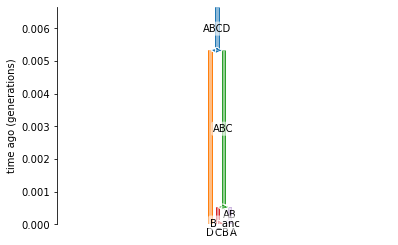

In [338]:
graph = msprime.Demography.to_demes(demography)
fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
demesdraw.tubes(graph, ax=ax, seed=1)
plt.show()

In [339]:
# ts.draw_svg(y_axis=True)

In [340]:
coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, coal_ABC)
cut_AB = t_1+cutpoints_AB(n_int_AB, t_2, coal_AB)
cut_AB_2 = np.array([t_1-t_m]+list(cut_AB)[1::])

left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1+t_2):
            state = (1, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        if mint>=(t_1+t_2):
            state = (3, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
        else:
            state = (4, (mint>cut_AB_2).sum()-1, (mint2>cut_ABC).sum()-1)
    else:
        state = (5, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)

In [341]:
set(tree_state)

{(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0)}

In [342]:
df = pd.DataFrame()
df['state'] = [str(i) for i in tree_state]
df['start'] = left_lst
df['end'] = right_lst
df

,state,start,end
0,"(0, 0, 0)",0.0,3234.0
1,"(0, 0, 0)",3235.0,5848.0
2,"(0, 0, 0)",5849.0,6317.0
3,"(0, 0, 0)",6318.0,7224.0
4,"(2, 0, 0)",7225.0,8109.0
...,...,...,...
12626,"(2, 0, 0)",9994894.0,9997579.0
12627,"(1, 0, 0)",9997580.0,9998369.0
12628,"(1, 0, 0)",9998370.0,9998899.0
12629,"(2, 0, 0)",9998900.0,9999144.0


In [343]:
%%R -i df -i n_sites

library(tidyverse)

tibble(df) %>%
    group_by(state) %>%
    summarize(total = sum(end-start)/n_sites)

# A tibble: 5 × 2
  state      total
  <chr>      <dbl>
1 (0, 0, 0) 0.644 
2 (1, 0, 0) 0.118 
3 (2, 0, 0) 0.0997
4 (3, 0, 0) 0.113 
5 (4, 0, 0) 0.0240


In [344]:
from trails.optimizer import trans_emiss_calc_introgression

transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc_introgression(
    t_1, t_1, t_1+t_2, t_2, t_upper, t_out, t_m,
    N_AB, N_ABC, r, m, n_int_AB, n_int_ABC)

starting

array([0.6638655 , 0.10020124, 0.10020124, 0.10020124, 0.03553079])